## Description:

        Investigate OTU classification in controls and mock community for the ERA MiSeq run



In [307]:
Controls = "/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/controls.rds"


In [308]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [309]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

In [310]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
}

In [311]:
%%R -i Controls
phy = readRDS(Controls)
phy = prune_taxa(taxa_sums(phy) > 3, phy)
phy 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 143 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 143 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 143 tips and 142 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [312]:
%%R
t = tax_table(phy)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(phy) = t

## Controls 

In [313]:
%%R
Mock = subset_samples(phy, X.sampleID == "MockComm")
Mock = prune_taxa(taxa_sums(Mock) > 3, Mock)

# NegControl = subset_samples(phy, X.sample %in% "NegControl-1")
# Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
# tax_table(Pos)
Mock_n = unique(tax_table(Mock)) %>% dim %>% .[1]


paste("Taxa included/OTUs recovered in MockCommunity: 27/", as.character(Mock_n), sep = "" )


[1] "Taxa included/OTUs recovered in MockCommunity: 27/45"


## Controls from previous runs

In [314]:
%%R

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt' 
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn_pick.tree'

physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq.RhizCG = merge_phyloseq(physeq,sample.data)


In [315]:
%%R
sample_names(physeq.RhizCG)
Mock.RhizCG = prune_samples("Mock_comm", physeq.RhizCG)
Mock.RhizCG = prune_taxa(taxa_sums(Mock.RhizCG) > 3, Mock.RhizCG)
rm(physeq.RhizCG)
Mock.RhizCG

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 33 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 33 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 33 tips and 32 internal nodes ]


In [316]:
%%R
t = tax_table(Mock.RhizCG)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(Mock.RhizCG) = t

In [317]:
%%R
Mock.Penn = readRDS('/home/bryan/PennRhiz/data/run1/phyloseq/buckleylab_pipeline/controls.rds')
Mock.Penn = prune_samples("MockCommunity-1", Mock.Penn)
Mock.Penn = prune_taxa(taxa_sums(Mock.Penn) > 3, Mock.Penn)

t = tax_table(Mock.Penn)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(Mock.Penn) = t
    
Mock.Penn

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 49 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 14 sample variables ]
tax_table()   Taxonomy Table:    [ 49 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 49 tips and 48 internal nodes ]


# Comparing mock community OTU composition to table of 'true' mock community composition

In [405]:
%%R 
mock.known = read.delim('/home/bryan/ERA/data/Hay-lab_mock_community.txt', header = TRUE, sep = '\t')
mock.known = mock.known %>% filter(Phylum != "" & Genus != "Candida") #removing archaea and fungi from mock comm

Mlength = dim(mock.known)[1]
mock.summary = mock.known %>%
    group_by(Phylum) %>%
    summarize(freq.known.norm = length(Phylum) / Mlength)

mock.summary %>% print(n = 20)

# A tibble: 7 × 2
           Phylum freq.known.norm
           <fctr>           <dbl>
1   Acidobacteria            0.04
2  Actinobacteria            0.16
3   Bacteroidetes            0.12
4   Cyanobacteria            0.04
5      Firmicutes            0.24
6  Proteobacteria            0.36
7 Verrucomicrobia            0.04


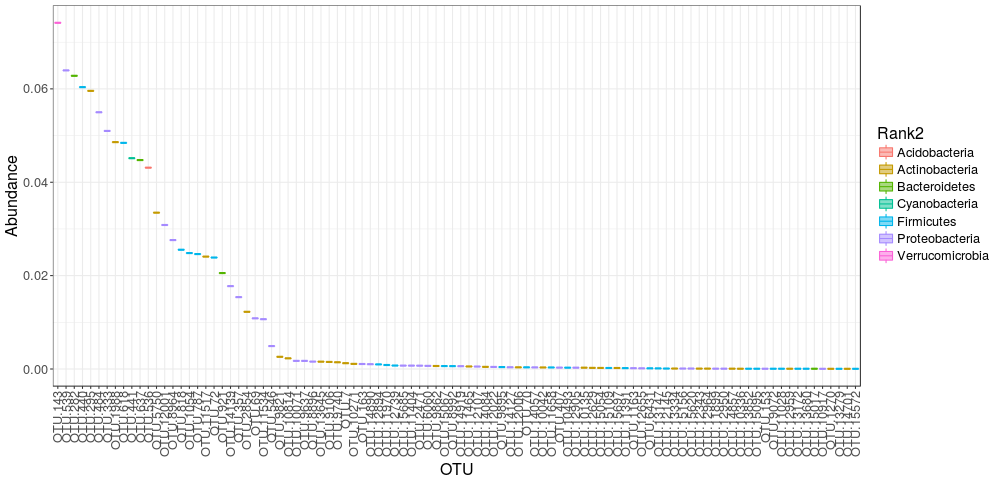

In [406]:
%%R -w 1000 
Mock.snorm = transform_sample_counts(Mock, function(x) x/sum(x))

tbl.otu = psmelt(Mock.snorm) %>%
        select(OTU, Abundance, Rank2, Rank5)

tbl.otu = tbl.otu %>%
    arrange(desc(Abundance)) %>%   # rearrange the df in the order we want (1,2,3,4,5)
    mutate(OTU = factor(OTU, OTU)) # relevel OTU in order
    
ggplot(tbl.otu, aes(OTU, Abundance, color=Rank2, fill=Rank2)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

27 OTUs at higher abundance, additional 18 OTUs at low abundance

## Comparing relative compositions of phylum

In [407]:
%%R
tbl.otu = psmelt(Mock.snorm) %>%
        group_by(Rank2) %>%
        summarize(relAbund = sum(Abundance))

Mock.Penn.snorm = transform_sample_counts(Mock.Penn, function(x) x/sum(x))
    tbl.otu.Penn = psmelt(Mock.Penn.snorm) %>%
        group_by(Rank2) %>%
        summarize(PennMockAbund = sum(Abundance))
    
Mock.RhizCG.snorm = transform_sample_counts(Mock.RhizCG, function(x) x/sum(x))
    tbl.otu.RhizCG = psmelt(Mock.RhizCG.snorm) %>%
        group_by(Rank2) %>%
        summarize(RhizMockAbund = sum(Abundance))

tbl.otu = full_join(tbl.otu, tbl.otu.RhizCG, by = c("Rank2" ="Rank2"))
tbl.otu = full_join(tbl.otu, tbl.otu.Penn , by = c("Rank2" ="Rank2"))
rm(tbl.otu.Penn,tbl.otu.RhizCG)
head(tbl.otu)

# A tibble: 6 × 4
           Rank2   relAbund RhizMockAbund PennMockAbund
          <fctr>      <dbl>         <dbl>         <dbl>
1  Acidobacteria 0.04312456    0.04394663    0.03045995
2 Actinobacteria 0.19362356    0.17982617    0.22758656
3  Bacteroidetes 0.12816529    0.12877953    0.13996345
4  Cyanobacteria 0.04515294    0.05006733    0.02000203
5     Firmicutes 0.21414468    0.16893133    0.18788710
6 Proteobacteria 0.30163457    0.38450239    0.31576810


In [408]:
%%R
# mock.known %>% head
mock.j = full_join(tbl.otu, mock.summary, c('Rank2' = 'Phylum')) %>%
    gather('variable', 'value', relAbund, RhizMockAbund, PennMockAbund, freq.known.norm) 
mock.j

# A tibble: 28 × 3
             Rank2      variable      value
             <chr>         <chr>      <dbl>
1    Acidobacteria      relAbund 0.04312456
2   Actinobacteria      relAbund 0.19362356
3    Bacteroidetes      relAbund 0.12816529
4    Cyanobacteria      relAbund 0.04515294
5       Firmicutes      relAbund 0.21414468
6   Proteobacteria      relAbund 0.30163457
7  Verrucomicrobia      relAbund 0.07415439
8    Acidobacteria RhizMockAbund 0.04394663
9   Actinobacteria RhizMockAbund 0.17982617
10   Bacteroidetes RhizMockAbund 0.12877953
# ... with 18 more rows


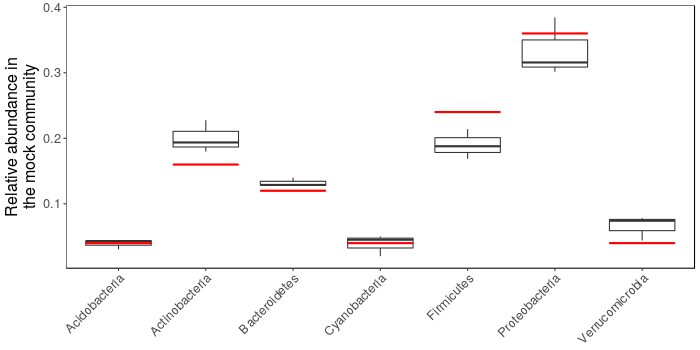

In [409]:
%%R -w 700 -h 350
Est = mock.j %>% filter(variable != "freq.known.norm")
Known = mock.j %>% filter(variable == "freq.known.norm")
p1 = ggplot(mock.j, aes(Rank2, value)) +
    geom_boxplot(data = Est, aes(Rank2, value)) +
   
    geom_boxplot(data = Known, aes(Rank2, value), color = 'red', alpha = 0.5) +
    labs(y='Relative abundance in\nthe mock community') +
    theme_pub()+
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, vjust=1, hjust=1),
        axis.title.x = element_blank()
        )
p1

## Comparing relative compositions at the Genus level 

In [412]:
%%R
mock.known = read.delim('/home/bryan/ERA/data/Hay-lab_mock_community.txt', header = TRUE, sep = '\t')
mock.known = mock.known %>% filter(Phylum != "" & Genus != "Candida") #removing archaea and fungi from mock comm

# mock.known = mock.known$genus %>% table %>% as.data.frame
# colnames(mock.known) = c('genus', 'freq.known')
SumKnown = length(mock.known$Genus) 
mock.summary = mock.known %>%
     group_by(Phylum,Family,Genus) %>%
     summarize (freq.known.norm = length(Genus) / SumKnown)

mock.summary %>% print(n = 25)

Source: local data frame [25 x 4]
Groups: Phylum, Family [?]

            Phylum              Family            Genus freq.known.norm
            <fctr>              <fctr>           <fctr>           <dbl>
1    Acidobacteria   Acidobacteriaceae   Acidobacterium            0.04
2   Actinobacteria      Micrococcaceae     Arthrobacter            0.04
3   Actinobacteria      Micrococcaceae          Kocuria            0.04
4   Actinobacteria      Micrococcaceae      Micrococcus            0.04
5   Actinobacteria     Nocardioidaceae     Nocardioides            0.04
6    Bacteroidetes   Flavobacteriaceae   Flavobacterium            0.04
7    Bacteroidetes   Flavobacteriaceae         Myroides            0.04
8    Bacteroidetes Sphingobacteriaceae Sphingobacterium            0.04
9    Cyanobacteria    Synechococcaceae    Synechococcus            0.04
10      Firmicutes         Bacillaceae         Bacillus            0.04
11      Firmicutes         Bacillaceae      Geobacillus            0.04
12

In [413]:
%%R
tbl.otu = psmelt(Mock.snorm) %>%
        mutate(Family = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", "Cyanobacteria"), as.character(Rank4), as.character(Rank5)),
        Genus = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", 
                                       "Cyanobacteria"), as.character(Rank5), as.character(Rank6))) %>%
        group_by(Rank2,Family,Genus) %>%
        summarize(relAbund = sum(Abundance)) %>%
        filter(relAbund > 0.001)%>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))

Mock.Penn.snorm = transform_sample_counts(Mock.Penn, function(x) x/sum(x))
    tbl.otu.Penn = psmelt(Mock.Penn.snorm) %>%
        mutate(Family = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", "Cyanobacteria"), as.character(Rank4), as.character(Rank5)),
        Genus = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", 
                                       "Cyanobacteria"), as.character(Rank5), as.character(Rank6))) %>%
        group_by(Rank2,Family,Genus) %>%
        summarize(PennMockAbund = sum(Abundance))%>%
        filter(PennMockAbund > 0.001)%>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))
    
Mock.RhizCG.snorm = transform_sample_counts(Mock.RhizCG, function(x) x/sum(x))
    tbl.otu.RhizCG = psmelt(Mock.RhizCG.snorm) %>%
        mutate(Family = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", "Cyanobacteria"), as.character(Rank4), as.character(Rank5)),
        Genus = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", 
                                       "Cyanobacteria"), as.character(Rank5), as.character(Rank6))) %>%
        group_by(Rank2,Family,Genus) %>%
        summarize(RhizMockAbund = sum(Abundance))%>%
        filter(RhizMockAbund > 0.001)%>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))


tbl.otu = full_join(tbl.otu, tbl.otu.RhizCG, by = c("Rank2" ="Rank2", "Family"="Family", "Genus"="Genus"))
tbl.otu = full_join(tbl.otu, tbl.otu.Penn , by = c("Rank2" ="Rank2", "Family"="Family", "Genus"="Genus"))
rm(tbl.otu.Penn,tbl.otu.RhizCG)
head(tbl.otu)

Source: local data frame [6 x 6]
Groups: Rank2, Family [3]

           Rank2            Family          Genus   relAbund RhizMockAbund
          <fctr>             <chr>          <chr>      <dbl>         <dbl>
1  Acidobacteria Acidobacteriaceae Acidobacterium 0.04312456    0.04394663
2 Actinobacteria    Micrococcaceae   Arthrobacter 0.11947996    0.12694332
3 Actinobacteria    Micrococcaceae        Kocuria 0.02836489            NA
4 Actinobacteria    Micrococcaceae    Micrococcus 0.04573556    0.04994491
5  Bacteroidetes Flavobacteriaceae Flavobacterium 0.06280412    0.05937079
6  Bacteroidetes Flavobacteriaceae       Myroides 0.02055349    0.02999143
# ... with 1 more variables: PennMockAbund <dbl>


In [414]:
%%R
# SumKnown = length(mock.known$Phylum) 
# mock.summary = mock.known %>%
#      group_by(Phylum,Family, Genus) %>%
#      summarize (freq.known.norm = length(Genus) / SumKnown)%>%
#         arrange(Phylum,Family) %>%
#         mutate(Genus = factor(Genus, Genus))
# head(mock.summary)

NULL


In [415]:
%%R
# mock.known %>% head
mock.j = full_join(tbl.otu, mock.summary, c('Rank2' = 'Phylum', "Family" = "Family", "Genus" = "Genus")) %>%
    gather('variable', 'value', relAbund, RhizMockAbund, PennMockAbund, freq.known.norm) %>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))
mock.j

Source: local data frame [136 x 5]
Groups: Rank2, Family [20]

            Rank2            Family          Genus        variable      value
            <chr>             <chr>         <fctr>           <chr>      <dbl>
1   Acidobacteria Acidobacteriaceae Acidobacterium        relAbund 0.04312456
2   Acidobacteria Acidobacteriaceae Acidobacterium   RhizMockAbund 0.04394663
3   Acidobacteria Acidobacteriaceae Acidobacterium   PennMockAbund 0.03045995
4   Acidobacteria Acidobacteriaceae Acidobacterium freq.known.norm 0.04000000
5  Actinobacteria    Micrococcaceae   Arthrobacter        relAbund 0.11947996
6  Actinobacteria    Micrococcaceae        Kocuria        relAbund 0.02836489
7  Actinobacteria    Micrococcaceae    Micrococcus        relAbund 0.04573556
8  Actinobacteria    Micrococcaceae             NA        relAbund         NA
9  Actinobacteria    Micrococcaceae   Arthrobacter   RhizMockAbund 0.12694332
10 Actinobacteria    Micrococcaceae        Kocuria   RhizMockAbund         NA
#

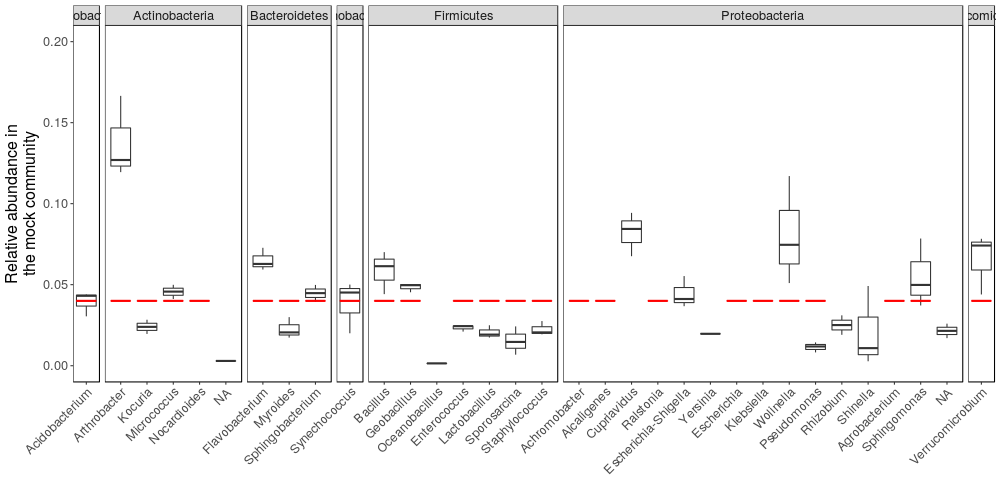

In [416]:
%%R -w 1000
Est = mock.j %>% filter(variable != "freq.known.norm") %>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))
Known = mock.j %>% filter(variable == "freq.known.norm") %>%
        arrange(Rank2,Family) %>%
        mutate(Genus = factor(Genus, Genus))
p2 = ggplot(mock.j, aes(Genus, value)) +
    geom_boxplot(data = Est, aes(Genus, value)) +
   
    geom_boxplot(data = Known, aes(Genus, value), color = 'red', alpha = 0.5) +
    labs(y='Relative abundance in\nthe mock community') +
    theme_pub()+
    ylim(0,0.2)+
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, vjust=1, hjust=1),
        axis.title.x = element_blank()
        )+
    facet_grid(~Rank2, scales = "free_x", space = "free_x")
p2

In [417]:
%%R
Est %>% filter(.,Genus == "Ralstonia")

Source: local data frame [3 x 5]
Groups: Rank2, Family [1]

           Rank2           Family     Genus      variable value
           <chr>            <chr>    <fctr>         <chr> <dbl>
1 Proteobacteria Burkholderiaceae Ralstonia      relAbund    NA
2 Proteobacteria Burkholderiaceae Ralstonia RhizMockAbund    NA
3 Proteobacteria Burkholderiaceae Ralstonia PennMockAbund    NA


### Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * 45 estimated compared to 27 actual
  * Estimation is better is low abundance taxa are filtered
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Good at the family level, but some mismatch in annotation

## Identify taxa in negative controls

In [331]:
%%R
sample_data(phy) %>% colnames

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"      


In [332]:
%%R
sample_sums(tmp)

        MockComm NegControl_Plate     NegControl_A     NegControl_B 
           92690              229               75             1247 
    NegControl_C 
              30 


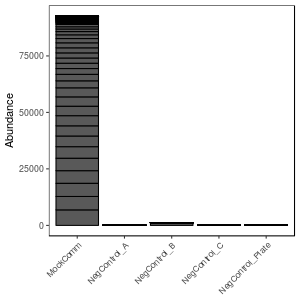

In [401]:
%%R -w 300 -h 300

tmp = subset_samples(phy, X.sampleID %in% c("NegControl_A","MockComm","NegControl_B", "NegControl_C", "NegControl_Plate"))

p3 = plot_bar(tmp, x = "Sample")+
        theme_pub() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust =1),
             axis.title.x = element_blank(), 
             legend.position = "none")
        #geom_text(aes(X.sampleID,sample_sums(tmp)))

p3
# p2 = plot_bar(phy, fill = 'Rank5', x = "Sample") +
#         theme_bw() +
#         theme(plot.title = element_text(face="bold", size=20)) +
#         guides(fill=guide_legend(ncol=2))

# grid.arrange(p1, p2, ncol=1)

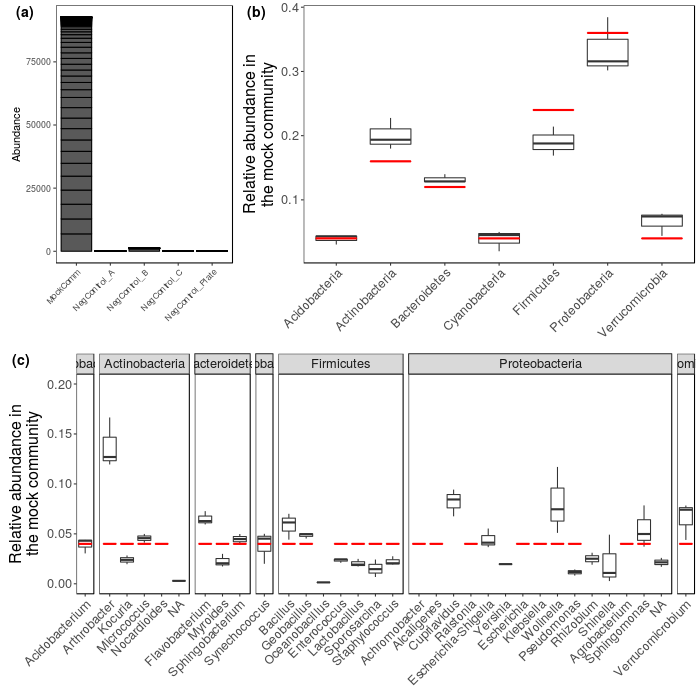

In [426]:
%%R -w 700 -h 700
require(cowplot)
pA = plot_grid(p3,p1, ncol = 2, align = "h", labels = c("(a)", "(b)"), rel_widths = c(1,2))
pB = plot_grid(pA, p2, ncol = 1, align = "v", labels = c("","(c)"))
pB

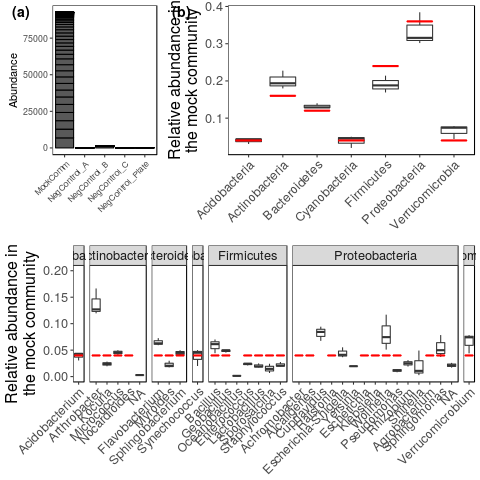

In [438]:
%%R
grid.arrange(pA, p2, ncol = 1)

In [444]:
%%R
pdf(file = '/home/bryan/ERA/data/figures/ms_versions/MockComm_v4.pdf', width = 6.5, height = 6.5)
#pL = plot_grid(pA, p2, ncol = 1, align = "v", labels = c("","(c)"))


pL = grid.arrange(pA, p2, ncol = 1)
print(pL)
dev.off()

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
png 
  2 


In [436]:
%%R
#ggsave(pB, filename = '/home/bryan/ERA/data/figures/ms_versions/MockComm_v3.pdf', width = 6.5, height = 5.5, units = "in")

## Save OTUs in negative controls

In [275]:
%%R
sample_sums(phy)

        MockComm PostiveControl_C NegControl_Plate     NegControl_A 
           92690               21              229               75 
    NegControl_B     PosControl_B     PosControl_A     NegControl_C 
            1247                7               15               30 
     IndexQC_Rev 
               0 


In [57]:
%%R
phy %>% sample_data %>%
    select(X.sampleID)

Sample Data:        [4 samples by 1 sample variables]:
                     X.sampleID
MockCommunity-1 MockCommunity-1
NegControl-1       NegControl-1
NegControl-2       NegControl-2
PosControl-1       PosControl-1


In [286]:
%%R
NegControl = subset_samples(phy, X.sampleID %in% c("NegControl_A","NegControl_B", "NegControl_C",
                                                    "NegControl_Plate"))

NegControl


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 143 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 143 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 143 tips and 142 internal nodes ]


In [293]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 3) > 0, TRUE) %>% taxa_names()

#Positives = filter_taxa(NegControl, function(x) sum(x > 0) < 1, TRUE) %>% taxa_names()

controls.FP = prune_taxa(FalsePositives, phy)  

controls.FP


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 40 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 40 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 40 tips and 39 internal nodes ]


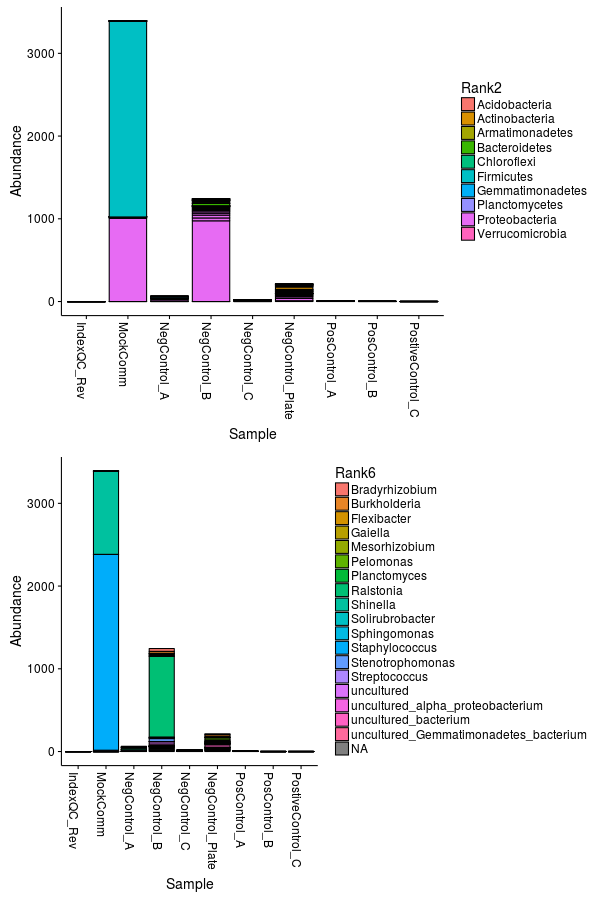

In [288]:
%%R -w 600 -h 900
# false positive composition in controls

p1 = plot_bar(controls.FP, fill = 'Rank2', x = "Sample")

p2 = plot_bar(controls.FP, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

In [289]:
%%R
tmp = controls.FP %>% subset_samples(X.sampleID == "MockComm")
tmp = prune_taxa(taxa_sums(tmp)>0, tmp)


In [290]:
%%R
mdf = psmelt(tmp)
mdf$relAbundance = mdf$Abundance / 92710

In [291]:
%%R
mdf %>% select(OTU, relAbundance, Rank2, Rank3, Rank4, Rank5, Rank6)

       OTU relAbundance          Rank2               Rank3           Rank4
4  OTU.818 2.554201e-02     Firmicutes             Bacilli      Bacillales
3   OTU.69 1.085104e-02 Proteobacteria Alphaproteobacteria     Rhizobiales
1 OTU.1163 1.725812e-04 Proteobacteria Gammaproteobacteria Xanthomonadales
2  OTU.679 1.078632e-05 Proteobacteria  Betaproteobacteria Burkholderiales
              Rank5            Rank6
4 Staphylococcaceae   Staphylococcus
3      Rhizobiaceae         Shinella
1  Xanthomonadaceae Stenotrophomonas
2  Burkholderiaceae        Ralstonia


# Check abundance of false positives in overall dataset

In [294]:
%%R
ERA = readRDS('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds')


    
#Filter to false positives
ERA.FP = prune_taxa(FalsePositives, ERA) 
ERA.FP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 30 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30 tips and 29 internal nodes ]


In [295]:
%%R
sample_data(ERA.FP)$Planted = ifelse(sample_data(ERA.FP)$Genotype == "Bare", "Bare", "Rhizosphere")

In [296]:
%%R
mdf = ERA.FP %>% 
    psmelt() 
MeanFP = mdf %>% 
    filter(TimePoint != "T0") %>%
    group_by(OTU, Rank2, Rank5, Rank6, Planted) %>%
    summarise(MeanAbund = mean(Abundance)) %>%
    arrange(desc(MeanAbund)) 



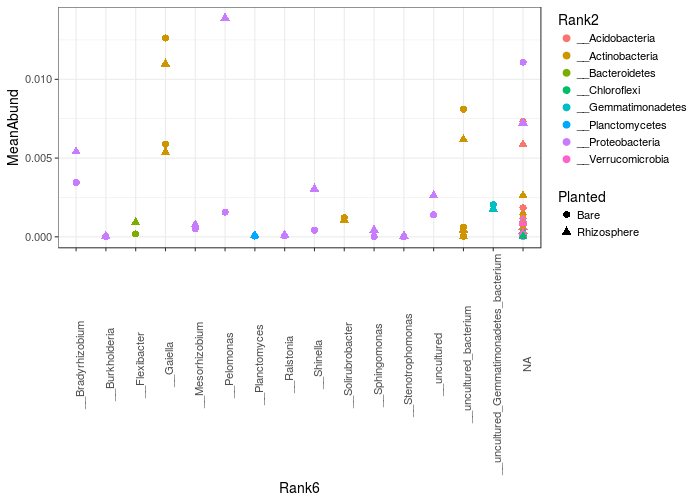

In [297]:
%%R -w 700 -h 500
ggplot(MeanFP, aes(x = Rank6, y = MeanAbund, shape = Planted, color = Rank2)) +
geom_point(size = 3)+
theme_bw(base_size = 14) +
theme(axis.text.x = element_text(angle = 90))

# Do negative controls display a biological pattern

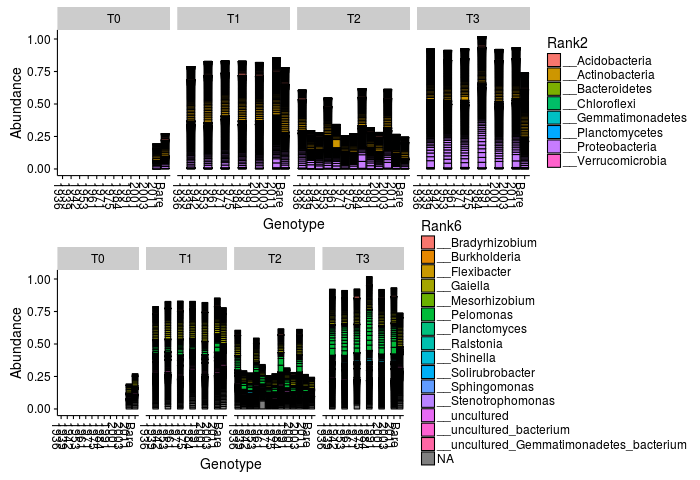

In [298]:
%%R -w 700


p1 = plot_bar(ERA.FP, fill = 'Rank2', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

p2 = plot_bar(ERA.FP, fill = 'Rank6', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

grid.arrange(p1, p2, ncol=1)

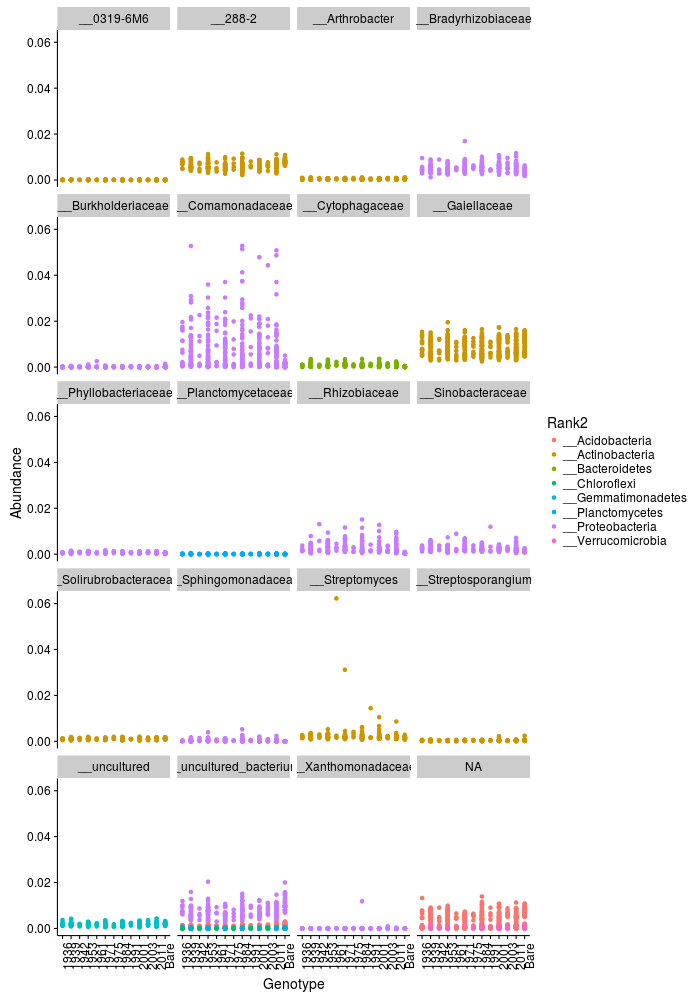

In [301]:
%%R -w 700 -h 1000
ggplot(mdf, aes(x = Genotype, y = Abundance, color = Rank2)) + 
    geom_point() + 
    facet_wrap(~Rank5, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90))

In [300]:
%%R
sample_sums(ERA.FP)

  ERA-T0_2-2c_0  ERA-T2_3-1d_85 ERA-T1_3-5c_170  ERA-T2_1-5a_85 ERA-T1_1-2b_170 
     0.06262795      0.07163106      0.06154792      0.06064649      0.06527888 
  ERA-T1_1-4b_0   ERA-T1_4-3d_0 ERA-T1_1-4a_170 ERA-T3_1-3c_170 ERA-T1_4-4a_170 
     0.07811165      0.06738013      0.06807974      0.08829839      0.07124860 
 ERA-T1_2-2b_85   ERA-T3_3-1c_0  ERA-T2_2-2d_85 ERA-T1_1-2d_170  ERA-T1_1-3c_85 
     0.07185586      0.07361143      0.06404944      0.07536570      0.06694205 
ERA-T3_3-4c_170  ERA-T2_1-3d_85  ERA-T2_4-3c_85  ERA-T1_1-2d_85 ERA-T3_3-2c_170 
     0.07809890      0.06923688      0.07626638      0.06931054      0.06799787 
 ERA-T3_4-3d_85   ERA-T0_1-5a_0 ERA-T3_2-5a_170 ERA-T3_3-1a_170 ERA-T1_1-3c_170 
     0.06216299      0.05668310      0.08874820      0.06868635      0.06473730 
 ERA-T2_1-2b_85  ERA-T3_2-2b_85  ERA-T2_1-2d_85  ERA-T3_4-1b_85   ERA-T3_2-5a_0 
     0.08903017      0.07170980      0.07802350      0.06993854      0.07251784 
  ERA-T1_4-1b_0   ERA-T3_1-4

* Negative controls show sequences
* There was no amplification of negative controls per gel visualization monitoring
* Of false positives, only pseudomonas shows up in appreciable ammounts in Mock community 
* Neg Control had only 1k reads, one tenth of the lowest sample count 
* Unlikely that contamination is contributing greatly to samples
* Genus designations are suspect